In [1338]:
import pandas as pd
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from pymorphy3 import MorphAnalyzer
from nltk.corpus import stopwords
import numpy as np
import torch.nn as nn
from sklearn.model_selection import train_test_split
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [1339]:
stopwords = stopwords.words('russian')

In [1340]:
df = pd.read_csv('./data/Petitions.csv')
df

id                               public_petition_text  \
0      3168490                                     снег на дороге   
1      3219678                очистить кабельный киоск от рекламы   
2      2963920  Просим убрать все деревья и кустарники, которы...   
3      3374910  Неудовлетворительное состояние парадной - надп...   
4      3336285                                           Граффити   
...        ...                                                ...   
59884  3128111                           прошу закрасить граффити   
59885  3276713       Прошу вас отремонтировать пешеходную дорожку   
59886  3274663  Необходимо демонтировать незаконную рекламную ...   
59887  3359308  Очень гремит на ветру металлическая часть окна...   
59888  3209098  Две проблемы в одном:\n1) Незаконные надписи/о...   

                                         reason_category  
0                                        Благоустройство  
1                                        Благоустройство  
2                                        Благоустройство  
3                                         Содержание МКД  
4                                        Благоустройство  
...                                                  ...  
59884                                    Благоустройство  
59885                                    Благоустройство  
59886  Незаконная информационная и (или) рекламная ко...  
59887                                             Кровля  
59888                                    Благоустройство  

[59889 rows x 3 columns]

In [1341]:
print(len(df['reason_category'].unique()), "\n", df['reason_category'].value_counts())

15 
 reason_category
Благоустройство                                                                     34769
Содержание МКД                                                                      14461
Нарушение правил пользования общим имуществом                                        2170
Незаконная информационная и (или) рекламная конструкция                              1831
Фасад                                                                                1483
Повреждения или неисправность элементов уличной инфраструктуры                       1164
Кровля                                                                                825
Водоснабжение                                                                         809
Состояние рекламных или информационных конструкций                                    673
Санитарное состояние                                                                  434
Центральное отопление                                                          

In [1342]:
df.drop(columns="id", inplace=True)

In [1343]:
new_df = df.sample(100)
new_df

public_petition_text  \
1504   Незаконная вывеска/рекламная конструкция по ад...   
54010           Проверить законность размещения вывески.   
26776  покрытие дворового проезда вдоль задания 120 к...   
47944                      Прошу убрать мусор с газонов.   
10886  Аварийное состояние стояка ХВС в квартире 91 (...   
...                                                  ...   
51906  На лестнице во втором подъезде на 4 этаже отсу...   
57719  Граффити на игровом домике\nПокосился флажок н...   
3306    прошу покрасить участок в цвет остального фасада   
41424  Мусор на внутридворовой территории.\nМешки на ...   
25216                  Отваливается штукатурка на стене.   

                                         reason_category  
1504   Незаконная информационная и (или) рекламная ко...  
54010  Незаконная информационная и (или) рекламная ко...  
26776                                    Благоустройство  
47944                                    Благоустройство  
10886                                      Водоснабжение  
...                                                  ...  
51906                                     Содержание МКД  
57719                                    Благоустройство  
3306                                               Фасад  
41424                                    Благоустройство  
25216                                              Фасад  

[100 rows x 2 columns]

In [1344]:
X = new_df["public_petition_text"].to_list()

In [1345]:
def preprocessing_text(text):
    lst = []
    #remove html
    for i in text:
        html_tag=re.compile('<.*?>')
        text_no_html = html_tag.sub('', i)
        #remove quots
        text_only_letters = re.sub('[^\w\s]', '', text_no_html)
        #tokenizим
        words = word_tokenize(text_only_letters)
        #morphим
        morph = MorphAnalyzer()
        lemmas = [morph.normal_forms(w)[0] for w in words]
        #del_sw
        prepared = [w for w in lemmas if w not in stopwords]
        lemm_sentce = ' '.join(prepared)
        lst.append(lemm_sentce)
        # lst.append(prepared)
    return lst


In [1346]:
prepro_text = preprocessing_text(text=X)
print(len(prepro_text))
prepro_text

100


['незаконный вывескарекламный конструкция адрес санктпетербург московский пр далее 103 установка 2 ворота центр',
 'проверить законность размещение вывеска',
 'покрытие дворовый проезд вдоль задание 120 корп2 покрыть наледь каша снег просьба выполнить уборка снег',
 'просить убрать мусор газон',
 'аварийный состояние стояк хвс квартира 91 9 этаж образоваться влага ржавый подтечь нарост место соединение металлический труба полипропиленовый труба стояк хвс фотография прилагаться октябрь 2018 г указанный стояк меняться частично протяжение 8 9 этаж остаться металлический часть стояк идти квартира 10 этаж заменить результат это место образоваться подтечь ржавый нарост декабрь 2020 год обращаться тсж вавилов 9 просьба заменить стояк хвс копия обращение прилагаться результат рассмотрение обращение получить ответ 11012021 год 01ио2021 нецелесообразность замена стояк копия прилагаться ответ тсж согласный аварийный состояние стояк хвс случай протечка мочь нанести ущерб имущество имущество жилец 

In [1347]:
def del_word_len_one(list_w):
    w_del = []
    for i in range(0, len(list_w)):
        if len(list_w[i].split()) < 3:
            w_del.append(i)
    for index in sorted(w_del, reverse=True):
        del list_w[index]
        
    return list_w

In [1348]:
new_prepro_text = del_word_len_one(prepro_text)
new_prepro_text

['незаконный вывескарекламный конструкция адрес санктпетербург московский пр далее 103 установка 2 ворота центр',
 'проверить законность размещение вывеска',
 'покрытие дворовый проезд вдоль задание 120 корп2 покрыть наледь каша снег просьба выполнить уборка снег',
 'просить убрать мусор газон',
 'аварийный состояние стояк хвс квартира 91 9 этаж образоваться влага ржавый подтечь нарост место соединение металлический труба полипропиленовый труба стояк хвс фотография прилагаться октябрь 2018 г указанный стояк меняться частично протяжение 8 9 этаж остаться металлический часть стояк идти квартира 10 этаж заменить результат это место образоваться подтечь ржавый нарост декабрь 2020 год обращаться тсж вавилов 9 просьба заменить стояк хвс копия обращение прилагаться результат рассмотрение обращение получить ответ 11012021 год 01ио2021 нецелесообразность замена стояк копия прилагаться ответ тсж согласный аварийный состояние стояк хвс случай протечка мочь нанести ущерб имущество имущество жилец 

In [1349]:
count_vocab = set((' '.join(new_prepro_text).split()))
word_to_ix = {word: i for i, word in enumerate(count_vocab)}
word_to_ix

{'скайнуть': 0,
 'куча': 1,
 'мера': 2,
 'частично': 3,
 'квалитет': 4,
 'остаться': 5,
 'пятьдесят': 6,
 'открываться': 7,
 'лифтовый': 8,
 'осколок': 9,
 'наполовину': 10,
 'должностной': 11,
 'простоять': 12,
 'платить': 13,
 'работать': 14,
 'река': 15,
 'внутридворовый': 16,
 'понимание': 17,
 'требоваться': 18,
 'к1': 19,
 'поребрик': 20,
 'асфальт': 21,
 'элемент': 22,
 'заменить': 23,
 'согласный': 24,
 '17го': 25,
 '14': 26,
 'исправно': 27,
 'собачей': 28,
 'тротуар': 29,
 'петросвязь': 30,
 'состояние': 31,
 'пять': 32,
 'пустой': 33,
 '2969878': 34,
 'почему': 35,
 'часть': 36,
 'гудеть': 37,
 'запах': 38,
 'строение': 39,
 'проводка': 40,
 'гуж': 41,
 'очередной': 42,
 '15': 43,
 'срабатывать': 44,
 'незаконный': 45,
 'библиотека': 46,
 'оборванный': 47,
 'академпарк': 48,
 'доводчик': 49,
 'грузовой': 50,
 'хронический': 51,
 'происходить': 52,
 'упавший': 53,
 'пулковский': 54,
 '2020': 55,
 'направлять': 56,
 'спасибо': 57,
 'покоситься': 58,
 'граффити': 59,
 'неприятн

In [1350]:
def get_context_words(data, m):
    central_words = []
    context_words = []
    s = []
    for k in range(0, len(data)):
        for i in range(m, (len(data[k].split()) - (m * 2)) + (m)):
            # print(i)
            central_word = data[k].split()[i]
            central_words.append(word_to_ix[central_word])

            context_word = []
            for j in range(i - m, i + m + 1):
                if j != i:
                    context_word.append(word_to_ix[data[k].split()[j]])
            context_words.append(context_word)

    s = list(zip(central_words, context_words))

    return s

In [1351]:
s = get_context_words(new_prepro_text, m=1)

In [1352]:
s

[(520, [45, 186]),
 (186, [520, 333]),
 (333, [186, 87]),
 (87, [333, 496]),
 (496, [87, 408]),
 (408, [496, 228]),
 (228, [408, 229]),
 (229, [228, 158]),
 (158, [229, 312]),
 (312, [158, 395]),
 (395, [312, 222]),
 (356, [513, 350]),
 (350, [356, 93]),
 (231, [210, 196]),
 (196, [231, 82]),
 (82, [196, 470]),
 (470, [82, 97]),
 (97, [470, 577]),
 (577, [97, 487]),
 (487, [577, 120]),
 (120, [487, 197]),
 (197, [120, 625]),
 (625, [197, 211]),
 (211, [625, 492]),
 (492, [211, 305]),
 (305, [492, 625]),
 (557, [329, 444]),
 (444, [557, 421]),
 (31, [584, 388]),
 (388, [31, 606]),
 (606, [388, 567]),
 (567, [606, 154]),
 (154, [567, 377]),
 (377, [154, 484]),
 (484, [377, 174]),
 (174, [484, 164]),
 (164, [174, 215]),
 (215, [164, 457]),
 (457, [215, 465]),
 (465, [457, 378]),
 (378, [465, 569]),
 (569, [378, 533]),
 (533, [569, 354]),
 (354, [533, 166]),
 (166, [354, 354]),
 (354, [166, 388]),
 (388, [354, 606]),
 (606, [388, 623]),
 (623, [606, 570]),
 (570, [623, 541]),
 (541, [570, 

In [1353]:
word_list = list(word_to_ix.keys())
word_list

['скайнуть',
 'куча',
 'мера',
 'частично',
 'квалитет',
 'остаться',
 'пятьдесят',
 'открываться',
 'лифтовый',
 'осколок',
 'наполовину',
 'должностной',
 'простоять',
 'платить',
 'работать',
 'река',
 'внутридворовый',
 'понимание',
 'требоваться',
 'к1',
 'поребрик',
 'асфальт',
 'элемент',
 'заменить',
 'согласный',
 '17го',
 '14',
 'исправно',
 'собачей',
 'тротуар',
 'петросвязь',
 'состояние',
 'пять',
 'пустой',
 '2969878',
 'почему',
 'часть',
 'гудеть',
 'запах',
 'строение',
 'проводка',
 'гуж',
 'очередной',
 '15',
 'срабатывать',
 'незаконный',
 'библиотека',
 'оборванный',
 'академпарк',
 'доводчик',
 'грузовой',
 'хронический',
 'происходить',
 'упавший',
 'пулковский',
 '2020',
 'направлять',
 'спасибо',
 'покоситься',
 'граффити',
 'неприятный',
 'внутри',
 'фанера',
 'сравнить',
 'мусорный',
 'день',
 '6',
 'включить',
 'устройство',
 'повод',
 'окурок',
 'остановка',
 'просесть',
 'мнение',
 'магнит',
 'парадный',
 'нарушать',
 'проводиться',
 'дело',
 'площадка',


In [1354]:
with open('word_list3.tsv', 'w', encoding='utf-8') as f:
    f.write('\n'.join(word_list))

In [1355]:
def embedding_matrix(f):
    count_vocab = set((' '.join(f).split()))
    print(len(count_vocab))
    word_to_ix = {word: i for i, word in enumerate(count_vocab)}
    print(word_to_ix)
    a = max(word_to_ix.values()) + 1
    print(a)
    matrica = [[0] * a for _ in range(a)]
    for k in range(0, len(f)):
        b = len(f[k].split())
        words = f[k].split()
        for i in range(b):
            for j in range(i+1, b):
                if words[i] in f[k] and words[j] in f[k]:
                    matrica[word_to_ix[words[i]]][word_to_ix[words[j]]] += 1
                    matrica[word_to_ix[words[j]]][word_to_ix[words[i]]] += 1

    # for row in matrica:
    #     print(row)
    
    return matrica

In [1356]:
emb_matr = embedding_matrix(new_prepro_text)
emb_matr

632
{'скайнуть': 0, 'куча': 1, 'мера': 2, 'частично': 3, 'квалитет': 4, 'остаться': 5, 'пятьдесят': 6, 'открываться': 7, 'лифтовый': 8, 'осколок': 9, 'наполовину': 10, 'должностной': 11, 'простоять': 12, 'платить': 13, 'работать': 14, 'река': 15, 'внутридворовый': 16, 'понимание': 17, 'требоваться': 18, 'к1': 19, 'поребрик': 20, 'асфальт': 21, 'элемент': 22, 'заменить': 23, 'согласный': 24, '17го': 25, '14': 26, 'исправно': 27, 'собачей': 28, 'тротуар': 29, 'петросвязь': 30, 'состояние': 31, 'пять': 32, 'пустой': 33, '2969878': 34, 'почему': 35, 'часть': 36, 'гудеть': 37, 'запах': 38, 'строение': 39, 'проводка': 40, 'гуж': 41, 'очередной': 42, '15': 43, 'срабатывать': 44, 'незаконный': 45, 'библиотека': 46, 'оборванный': 47, 'академпарк': 48, 'доводчик': 49, 'грузовой': 50, 'хронический': 51, 'происходить': 52, 'упавший': 53, 'пулковский': 54, '2020': 55, 'направлять': 56, 'спасибо': 57, 'покоситься': 58, 'граффити': 59, 'неприятный': 60, 'внутри': 61, 'фанера': 62, 'сравнить': 63, 'му

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [1357]:
from sklearn.decomposition import PCA

In [1358]:
pca = PCA(n_components=30)
pca.fit(emb_matr)
data_pca = pca.transform(emb_matr)

In [1359]:
np.savetxt('embeddings.tsv', data_pca, delimiter='\t')

## Neural_buri

In [1360]:
# [(256, [23, 45])
# (256, [23, 45])
# (256, [23, 45])]
X_i = np.array([])
y_i = np.array([])
for i, j in s:
    y_i = np.insert(y_i, 0, i)
    X_i = np.insert(X_i, 0, j).reshape(-1, 2)

In [1361]:
X_train, X_test, y_train, y_test = train_test_split(X_i, y_i, test_size=0.15)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((779, 2), (138, 2), (779,), (138,))

In [1362]:
batch_size = 256
train_ds = TensorDataset(torch.from_numpy(X_train).type(torch.long), torch.from_numpy(y_train).type(torch.long))
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [1363]:
train_dl.batch_size

256

In [1364]:
# class CBOWModeler(nn.Module):  
#     def __init__(self, vocab_size, embedding_dim):
#         super(CBOWModeler, self).__init__()
#         self.embeddings = nn.Embedding(vocab_size, embedding_dim)
#         self.linear1 = nn.Linear(embedding_dim, 250)
#         self.linear2 = nn.Linear(250, vocab_size)

#     def forward(self, inputs):
#         #Size(256, 2, 10)
#         #batch_size x context * 2 x embedding_dim
#         #.mean(1) batch_size x context * 1 x embedding_dim
#         embeds = (self.embeddings(inputs)).mean(1)
#         out1 = F.tanh(self.linear1(embeds))
#         out2 = self.linear2(out1)           
#         log_probs = F.log_softmax(out2, dim=1)
#         return log_probs


class CBOWModeler(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOWModeler, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Embedding(vocab_size, embedding_dim),
            nn.Linear(embedding_dim, 250),
            nn.Linear(250, vocab_size),
            nn.LogSoftmax(dim=1)
        )
    def forward(self, x):
        y = self.linear_relu_stack(x).mean(1)
        return y
    

In [1365]:
loss_function = nn.NLLLoss()

In [1366]:
model = CBOWModeler(len(count_vocab), 10)
model

CBOWModeler(
  (linear_relu_stack): Sequential(
    (0): Embedding(632, 10)
    (1): Linear(in_features=10, out_features=250, bias=True)
    (2): Linear(in_features=250, out_features=632, bias=True)
    (3): LogSoftmax(dim=1)
  )
)

In [1367]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [1368]:
wordvecs = model.linear_relu_stack[2].weight.cpu().detach().numpy()
wordvecs

array([[-0.03535303,  0.04067893,  0.0168101 , ...,  0.04372499,
         0.05549807,  0.02434002],
       [-0.01510011, -0.06228026, -0.05769707, ...,  0.04353647,
        -0.04861682,  0.04456247],
       [ 0.05144221, -0.0508795 ,  0.04840279, ..., -0.00509853,
        -0.02639112, -0.03316309],
       ...,
       [-0.03426373, -0.03418601,  0.01546548, ...,  0.01303357,
        -0.00620953,  0.02116445],
       [ 0.0218838 ,  0.02962691,  0.02562145, ...,  0.02767932,
        -0.00978514, -0.03326246],
       [ 0.05741104,  0.00977904, -0.0483255 , ...,  0.0573962 ,
         0.02775603,  0.03891978]], dtype=float32)

In [1369]:
np.savetxt('word2vec_vectors.tsv', wordvecs, delimiter='\t')

In [1370]:
epochs = 40

loss_values = []
for epoch in range(epochs):
    for x_b, y_b in train_dl:

        outputs = model(x_b)
        loss_value = loss_function(outputs, y_b)

        loss_value.backward()

        optimizer.step()

        optimizer.zero_grad()
    loss_values.append(loss_value.item())

    print(f'Эпоха {epoch + 1}, Значение функции потерь: {loss_value.item()}')

Эпоха 1, Значение функции потерь: 0.7625417113304138
Эпоха 2, Значение функции потерь: 0.7070624828338623
Эпоха 3, Значение функции потерь: 0.7052675485610962
Эпоха 4, Значение функции потерь: 0.7531419992446899
Эпоха 5, Значение функции потерь: 0.7075852751731873
Эпоха 6, Значение функции потерь: 0.7192195057868958
Эпоха 7, Значение функции потерь: 0.7156713604927063
Эпоха 8, Значение функции потерь: 0.715938150882721
Эпоха 9, Значение функции потерь: 0.7292852997779846
Эпоха 10, Значение функции потерь: 0.7394737005233765
Эпоха 11, Значение функции потерь: 0.7222020030021667
Эпоха 12, Значение функции потерь: 0.7074806094169617
Эпоха 13, Значение функции потерь: 0.722429096698761
Эпоха 14, Значение функции потерь: 0.7216235399246216
Эпоха 15, Значение функции потерь: 0.7433534860610962
Эпоха 16, Значение функции потерь: 0.7301744818687439
Эпоха 17, Значение функции потерь: 0.6984955072402954
Эпоха 18, Значение функции потерь: 0.7102523446083069
Эпоха 19, Значение функции потерь: 0.70

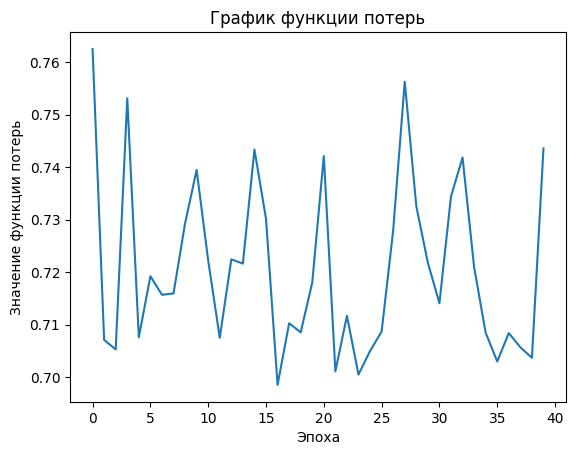

In [1371]:
plt.plot(loss_values)
plt.xlabel('Эпоха')
plt.ylabel('Значение функции потерь')
plt.title('График функции потерь')
plt.show()